# Introduction à QAOA avec PennyLane

### basée sur https://pennylane.ai/qml/demos/tutorial_qaoa_intro et https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut

Commençons tout de suite en définissant un Hamiltonien. voici comment c'est fait en Pennylane :

In [ ]:
%pip install pennylane

In [11]:
import pennylane as qml
# à noté que @ est un produit tensorielle. donc ici on fait le produit tensorielle entre deux porte PauliX
# voir https://docs.pennylane.ai/en/stable/code/api/pennylane.ops.op_math.LinearCombination.html pour plus de détails sur qml.Hamiltonian
H = qml.Hamiltonian([1, 1, 0.5], [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]) 
# ici c'est comme si on faisait 1*PauliX 1*PauliZ et 0.5 * (PauliX @ PauliX). le premier argument sont les coefficients pour les "observables" du deuxième argument
print(H)

1 * X(0) + 1 * Z(1) + 0.5 * (X(0) @ X(1))


L'opérateur d'évolution temporelle (time evolution operator) peut être décrit comme étant $ U(H, t) = e^{-i H t / \hbar} $ grace à cette propriété, on peu représenter des circuits quantiques comme étant un hamiltonian

tout les opérateurs unitaire $ U $ peuvent être écrit sous la forme $ U = e^{i \gamma H} $

où $\gamma$ est un scalaire (un nombre) et $ H $ est un opérateur hermitian (Hermitian operator).



Pour approximé un time-evolution unitary, un peu définir les équations suivantes :
$$
U(H, t, n) = \prod_{j=1}^{n} \prod_{k} e^{-i H_k \frac{t}{n}}
$$

$$
H = \sum_{k} H_k,
$$

où $ U $ approche $e^{-i H t}$  quand $ n $ devient grand.

tout ça est implémenter avec la fonction qml.ApproxTimeEvolution(hamiltonian, time, n, id=None) de pennylane. (l'argument id sert juste à mettre une étiquette sur une instance spécifique)


In [2]:
dev = qml.device("default.qubit", wires=2)

t = 1
n = 2


@qml.qnode(dev)
def circuit():
    qml.ApproxTimeEvolution(H, t, n) # voir https://docs.pennylane.ai/en/stable/code/api/pennylane.ApproxTimeEvolution.html pour plus de détails
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]


print(qml.draw(circuit, level="device")())

0: ──RX(1.00)─╭RXX(0.50)──RX(1.00)─╭RXX(0.50)─┤  <Z>
1: ──RZ(1.00)─╰RXX(0.50)──RZ(1.00)─╰RXX(0.50)─┤  <Z>


pour divers raisons, on se ramasse à vouloir repeter des parties de notre circuit souvent. ça peut être fait avec qml.layer(template, depth, *args, **kwargs) 

voir https://docs.pennylane.ai/en/stable/code/api/pennylane.layer.html#pennylane.layer

In [3]:
# example avec "un layer" seulement :
def circ(theta):
    qml.RX(theta, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])


@qml.qnode(dev)
def circuit(param):
    circ(param)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]


print(qml.draw(circuit)(0.5))

0: ──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X─┤  <Z>


In [4]:
# example avec un nombre arbitraire (ici 3) layer :
@qml.qnode(dev)
def circuit(params, **kwargs):
    qml.layer(circ, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]


print(qml.draw(circuit)([0.3, 0.4, 0.5]))

0: ──RX(0.30)─╭●──RX(0.40)─╭●──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X──H────────╰X──H────────╰X─┤  <Z>


L'algorithme quantique d'approximation pour l'optimisation (quantum approximate optimization algorithm, QAOA) est une technique générale qui peut être utilisée pour trouver des solutions approximatifs à des problèmes d'optimisation combinatoire, en particulier des problèmes pouvant être formulés en recherche d'une chaîne binaire optimale. Voici les étapes générales de QAOA :

1. **Définir un Hamiltonien de coût $H_C$** tel que son état fondamental (ground state) encode la solution au problème d'optimisation.

2. **Définir un Hamiltonien de mélange $H_M$**

3. **Construire les circuits** $e^{-i\gamma H_C}$ **et** $e^{-i\alpha H_M}$. Nous appelons respectivement ces circuits les couches de coût et de mélange.

4. **Choisir un paramètre $n \ge 1$ et construire le circuit :**

   $$
   U(\gamma, \alpha) = e^{-i\alpha_n H_M}\, e^{-i\gamma_n H_C}\, \dots\, e^{-i\alpha_1 H_M}\, e^{-i\gamma_1 H_C},
   $$

   qui consiste de plusieurs couches de coût et de mélange en répétition.

5. **Préparer un état initial, appliquer $U(\gamma, \alpha)$ et utiliser des techniques classiques pour optimiser les paramètres.**

6. **Après l'optimisation du circuit, les mesures de l'état de sortie révèlent des solutions approximatifs au problème d'optimisation.**

En résumé, **le point de départ de QAOA est la spécification des Hamiltoniens de coût et de mélange**. Nous utilisons ensuite l'évolution temporelle et l'empilement de couches (layers, répétition de circuits) pour créer un circuit variationnel et optimiser ses paramètres. L'algorithme se conclut par un échantillonnage du circuit afin d'obtenir une solution approchée au problème d'optimisation.


# Example d'application de QAOA pour trouver le "minimum vertex cover" d'un graph 

le but du problème du "minimum vertex cover" est de trouver une collection de vertex "coloré" pour lesquels tout les arêtes dans le graphique contienne au moin un vertex "coloré" ("in the cover") ![title](img/minvc.png)

La sortie de QAOA est une chaine binaire, dans le cas démontrer ici, la chaine serait 01010 (le deuxième vertex et le quatrième vertex)
les numéros des vertex ne sont pas afficher dans le graphs, mais sachez que c'est le vertex 2 et 4 qui sont coloré

In [3]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

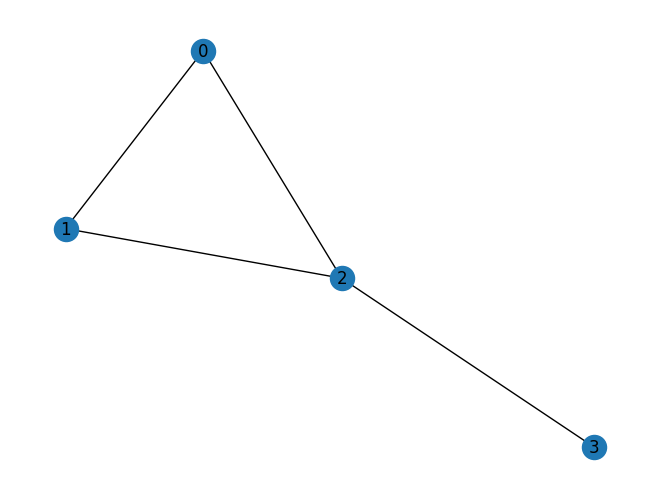

In [6]:
# prenez le temps de comprendre comment la list edges forme le graphique afficher sous ce code
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)
positions = nx.spring_layout(graph, seed=1)

nx.draw(graph, with_labels=True, pos=positions)
plt.show()

solutions possibles à ce graph : 1010 et 0110, c'est le resultats qu'on veux avoir après l'execution de QAOA

Pennylane fournis déjà des hamiltonians de coût et de mixage pour plein de problème d'optimisation. pour voir la liste de tout les problèmes de base que QAOA permet de réglé, voir https://docs.pennylane.ai/en/stable/code/qml_qaoa.html

on voit dans la documentation qu'ils ont déjà implémenter une fonction QAOA pour le problème min_vertex_cover, c'est ça qu'on va utiliser

In [ ]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False) # avec jacob aujourd'hui on va apprendre à comment reconstruire cost_h pour résoudre des problèmes custom!

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(1) @ Z(2)) + 0.75 * Z(1) + 0.75 * Z(2) + 0.75 * (Z(2) @ Z(3)) + 0.75 * Z(2) + 0.75 * Z(3) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


In [8]:
#on utilise des variable global dans une fonction, pas idéal
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [ ]:
# maintenant on crée le circuit variationel pour résoudre le problème
wires = range(4)
depth = 2


def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1]) # params[0] et params[1] permet de passer les arguments, ici gamma et alpha, dans le circuit

In [16]:
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [17]:
optimizer = qml.GradientDescentOptimizer() # optimisation classic avec la descente de gradient
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

In [18]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.59806352 0.94198485]
 [0.52797281 0.85552845]]


In [19]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

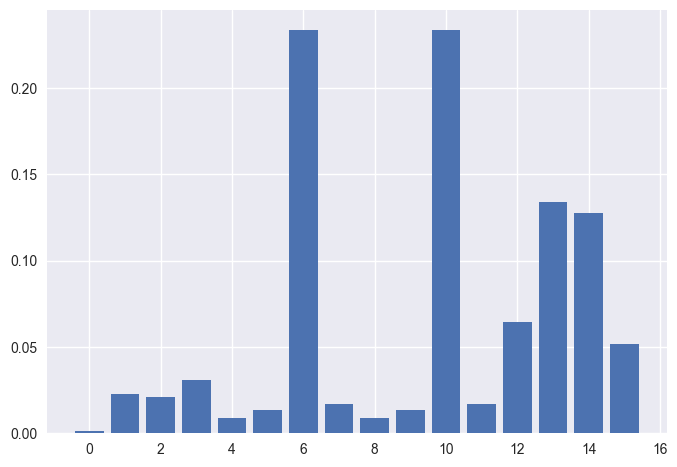

In [22]:
plt.style.use("seaborn-v0_8")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

In [28]:
# référence pour voir l'équalent des nombres en binaire.
for i in range(17):
    print(f"{i}:{'{0:04b}'.format(i)}")

0:0000
1:0001
2:0010
3:0011
4:0100
5:0101
6:0110
7:0111
8:1000
9:1001
10:1010
11:1011
12:1100
13:1101
14:1110
15:1111
16:10000


On remarque que 6 (0110) et 10 (1010) sont les deux valeurs qui ressortes

présentement, on a deux résultat, mais on peut ajouter des contraintes pour mettre une préférence de sorte que seulement un des deux résultats ressort

In [34]:
reward_h = qaoa.edge_driver(nx.Graph([(0, 2)]), ["11"]) # edge_driver assign une énergie plus faibles à l'état 11, peut importe où dans le bitstring
# voir https://docs.pennylane.ai/en/stable/code/api/pennylane.qaoa.cost.edge_driver.html pour les détails
new_cost_h = cost_h + 2 * reward_h # ici on dit que 11 est plus couteux, donc moin de chance de voir 0110 sortir

In [35]:
# meme affaire que plus haut, mais la on utilise la nouvelle fonction de cout
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, new_cost_h)
    qaoa.mixer_layer(alpha, mixer_h)


def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])


@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(new_cost_h)


params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.45959941 0.96095271]
 [0.27029962 0.78042396]]


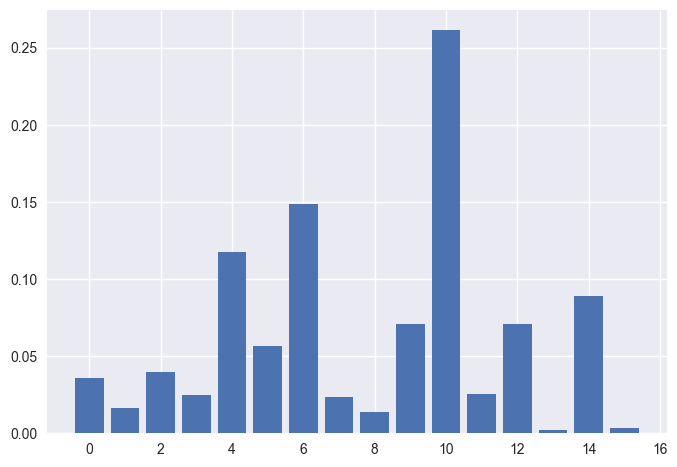

In [36]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

plt.style.use("seaborn-v0_8")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

Après l'application du reward sur l'hamiltonian, on voit que seulement 10 ressort